# Corona Virus Exploratory Analysis and Modeling 

![](https://cdn.cnn.com/cnnnext/dam/assets/200130165125-corona-virus-cdc-image-super-tease.jpg)

# 1. Import Library

In [1]:
# System
import sys
import os
import operator
import argparse
import itertools

# Time
import time
import datetime
from datetime import datetime
from time import gmtime, strftime
from pytz import timezone

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix


from wordcloud import WordCloud

# Image
import cv2
from PIL import Image

from IPython.display import display
from IPython.core.display import HTML


# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['corona-virus-time-series-dataset']


### Time of last edit

In [2]:
def print_time():
    fmt = "%a, %d %B %Y %H:%M:%S %Z%z"
    
    pacific = timezone('US/Pacific')
    
    loc_dt = datetime.now(pacific)
    
    time_str = loc_dt.strftime(fmt)
    
    print("Pacific Time" + " : " + time_str)
    
    return time_str
    

In [3]:
def format_date_columns(data_cols):
    data_cols_new_format = []
    data_cols_map = {}
    
    for d in data_cols:
        new_d = datetime.strftime(datetime.strptime(d, '%m/%d/%y'),'%b %d')
        data_cols_map[d] = new_d
        data_cols_new_format.append(new_d)
    
    return data_cols_new_format, data_cols_map

In [4]:
def fatality_rate_func(country="Total", state=""):
    if not state == "":
        return (time_series_covid_19_deaths[time_series_covid_19_deaths["Province/State"]==state][data_cols].sum()/time_series_covid_19_confirmed[time_series_covid_19_confirmed["Province/State"]==state][data_cols].sum())*100
    elif country == "Total":
        return (time_series_covid_19_deaths[data_cols].sum()/time_series_covid_19_confirmed[data_cols].sum())*100
    else:
        return (time_series_covid_19_deaths[time_series_covid_19_deaths["Country/Region"]==country][data_cols].sum()/time_series_covid_19_confirmed[time_series_covid_19_confirmed["Country/Region"]==country][data_cols].sum())*100

In [5]:
cur_time_str = print_time()

Pacific Time : Tue, 24 March 2020 11:39:30 PDT-0700


# 2. Read Data

In [6]:
input_dir = "../input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

In [7]:
time_series_covid_19_confirmed = pd.read_csv(input_dir + "time_series_19-covid-Confirmed.csv")
time_series_covid_19_recovered = pd.read_csv(input_dir + "time_series_19-covid-Recovered.csv")
time_series_covid_19_deaths    = pd.read_csv(input_dir + "time_series_19-covid-Deaths.csv")

# 3. Data Preprocessing

In [8]:
columns = time_series_covid_19_confirmed.columns.tolist()
location_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
location_long_lat_columns = ['Lat', 'Long']
location_name_cols = ['Country/Region', 'Province/State']

data_cols = [c for c in columns if c not in location_columns]

count_days = len(data_cols)

Change date format to string

In [9]:
data_cols_new_format, data_cols_map = format_date_columns(data_cols)

last_day = data_cols_new_format[-1]
prev_day = data_cols_new_format[-2]

new_cols = location_name_cols + [last_day]

In [10]:
time_series_covid_19_confirmed.rename(columns=data_cols_map, inplace=True)
time_series_covid_19_recovered.rename(columns=data_cols_map, inplace=True)
time_series_covid_19_deaths.rename(columns=data_cols_map, inplace=True)

In [11]:
country_list = time_series_covid_19_confirmed['Country/Region'].unique().tolist()
country_list.sort()

state_list = time_series_covid_19_confirmed['Province/State'].unique().tolist()
# state_list.sort()

In [12]:
last_confirmed_df = time_series_covid_19_confirmed[location_name_cols + [last_day]].copy()
last_confirmed_df.rename(columns = {last_day: "Confirmed"}, inplace=True)

last_add_confirmed_df = time_series_covid_19_confirmed[location_name_cols + [prev_day, last_day]].copy()
last_add_confirmed_df["New Confirmed"] = last_add_confirmed_df[last_day] - last_add_confirmed_df[prev_day]
last_add_confirmed_df.drop(columns = [prev_day, last_day], inplace=True)

last_recovered_df = time_series_covid_19_recovered[location_name_cols + [last_day]].copy()
last_recovered_df.rename(columns = {last_day: "Recovered"}, inplace=True)

last_add_recovered_df = time_series_covid_19_recovered[location_name_cols + [prev_day, last_day]].copy()
last_add_recovered_df["New Recovered"] = last_add_recovered_df[last_day] - last_add_recovered_df[prev_day]
last_add_recovered_df.drop(columns = [prev_day, last_day], inplace=True)

last_death_df = time_series_covid_19_deaths[location_name_cols + [last_day]].copy()
last_death_df.rename(columns = {last_day: "Death"}, inplace=True)

last_add_death_df = time_series_covid_19_deaths[location_name_cols + [prev_day, last_day]].copy()
last_add_death_df["New Death"] = last_add_death_df[last_day] - last_add_death_df[prev_day]
last_add_death_df.drop(columns = [prev_day, last_day], inplace=True)


In [13]:
result1 = last_confirmed_df.merge(last_add_confirmed_df, on = ["Country/Region", "Province/State"])

result2 = result1.merge(last_recovered_df, on = ["Country/Region", "Province/State"])
result3 = result2.merge(last_add_recovered_df, on = ["Country/Region", "Province/State"])

result4 = result3.merge(last_death_df, on = ["Country/Region", "Province/State"])
result = result4.merge(last_add_death_df, on = ["Country/Region", "Province/State"])

In [14]:
result ["Active"] = result["Confirmed"] - (result["Recovered"] + result["Death"])

In [15]:
result_country = result.groupby(['Country/Region']).sum()

In [16]:
result_country["Persistence Rate"] = ((result_country["Active"]/result_country["Confirmed"])*100)
result_country["Fatality Rate"] = ((result_country["Death"]/result_country["Confirmed"])*100)
result_country["Recovery Rate"] = ((result_country["Recovered"]/result_country["Confirmed"])*100)

In [17]:
total_confirmed_global = result_country[['Confirmed']].sum().values[0]
total_recovered_global = result_country[['Recovered']].sum().values[0]
total_death_global = result_country[['Death']].sum().values[0]

total_active_global = result_country[['Active']].sum().values[0]

new_confirmed_global = result_country[['New Confirmed']].sum().values[0]
new_recovered_global = result_country[['New Recovered']].sum().values[0]
new_death_global = result_country[['New Death']].sum().values[0]

new_active_global = new_confirmed_global - (new_recovered_global + new_death_global)


global_persistence_rate = (total_active_global / total_confirmed_global) * 100
global_recovery_rate = (total_recovered_global / total_confirmed_global) * 100
global_fatality_rate = (total_death_global / total_confirmed_global) * 100

In [18]:
m_sum = {"Total Confirmed (Global)": [total_confirmed_global], 
         "Total Active (Global)"   : [total_active_global],
         "Total Recovered (Global)": [total_recovered_global], 
         "Total Deaths (Global)"   : [total_death_global]}


global_sum_df = pd.DataFrame.from_dict(m_sum)

In [19]:
m_sum = {"New Confirmed (Global)": [new_confirmed_global], 
         "New Active (Global)"   : [new_active_global],
         "New Recovered (Global)": [new_recovered_global], 
         "New Deaths (Global)"   : [new_death_global]}


global_sum_df = pd.DataFrame.from_dict(m_sum)

In [20]:
m_rate = {"Global Persistence Rate (%)": [global_persistence_rate],
          "Global Recovery Rate (%)"   : [global_recovery_rate],
          "Global Fatality Rate (%)"   : [global_fatality_rate]
         }

global_sum_df = pd.DataFrame.from_dict(m_rate)

In [21]:
print("Current Global Stats")
print("-"*40)
print("Total Confimed  (Current Global): %d" % (total_confirmed_global))
print("Total Active    (Current Global): %d" % (total_active_global))
print("Total Recovered (Current Global): %d" % (total_recovered_global))
print("Total Deaths    (Current Global): %d" % (total_death_global))

Current Global Stats
----------------------------------------
Total Confimed  (Current Global): 336004
Total Active    (Current Global): 223027
Total Recovered (Current Global): 98334
Total Deaths    (Current Global): 14643


In [22]:
print("Current Global Stats")
print("-"*40)
print("New Confimed  (Global): %d" % (new_confirmed_global))
# print("New Active    (Global): %d" % (new_active_global))
print("New Recovered (Global): %d" % (new_recovered_global))
print("New Deaths    (Global): %d" % (new_death_global))



Current Global Stats
----------------------------------------
New Confimed  (Global): 52
New Recovered (Global): 630
New Deaths    (Global): 11


In [23]:
print("Current Global Rates (Percentile)")
print("-"*40)
print("Global Persistence Rate : %d " % (global_persistence_rate))
print("Global Recovery Rate    : %d " % (global_recovery_rate))
print("Global Fatality Rate    : %d " % (global_fatality_rate))

Current Global Rates (Percentile)
----------------------------------------
Global Persistence Rate : 66 
Global Recovery Rate    : 29 
Global Fatality Rate    : 4 


# 4. Visualization

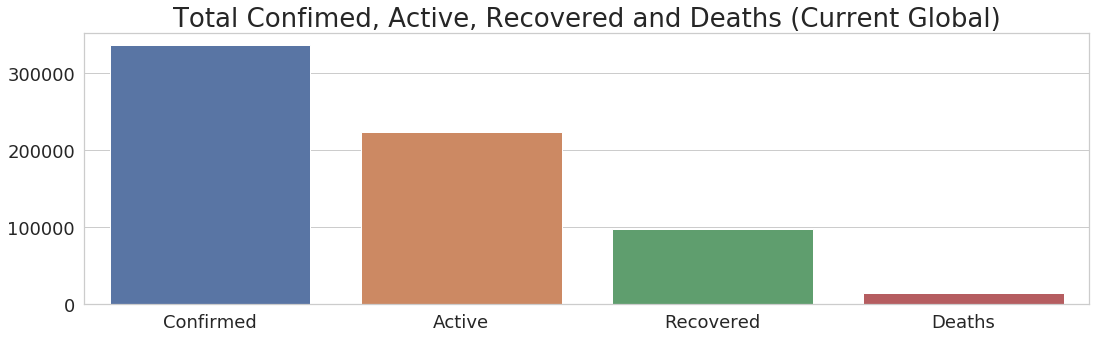

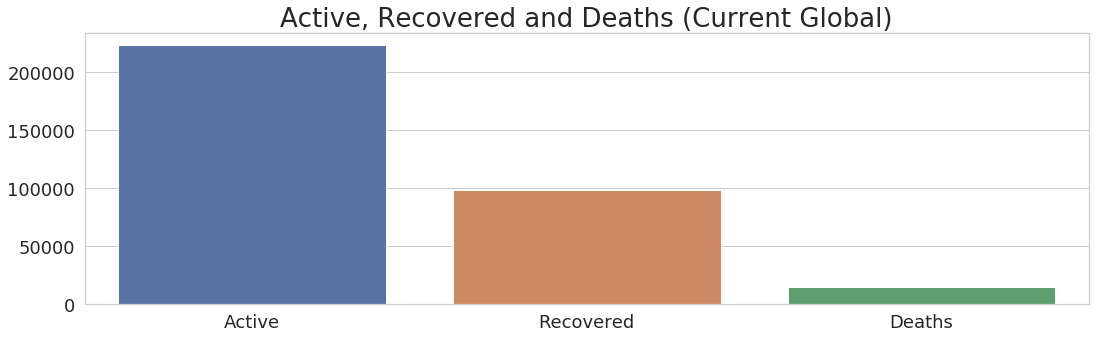

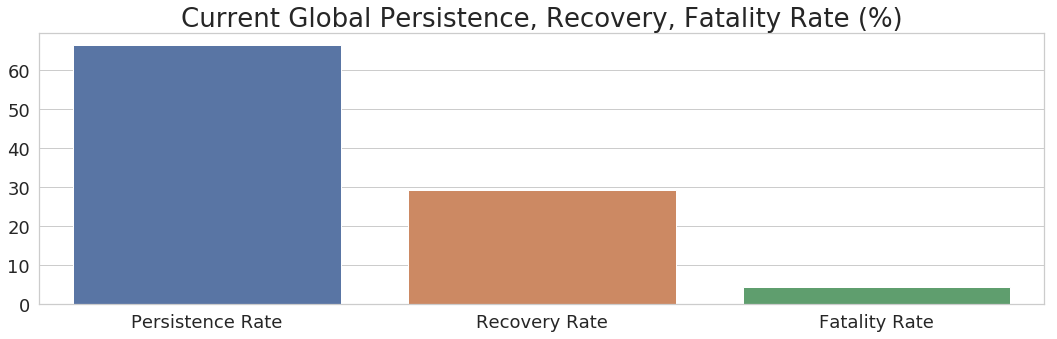

In [24]:
sns.set(style="whitegrid")

ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)



data = [total_confirmed_global, total_active_global, total_recovered_global, total_death_global]
labels = ["Confirmed", "Active", "Recovered", "Deaths"]

title    = "Total Confimed, Active, Recovered and Deaths (Current Global)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show() 
    
    

data = [total_active_global, total_recovered_global, total_death_global]
labels = ["Active", "Recovered", "Deaths"]

title = "Active, Recovered and Deaths (Current Global)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show() 
   


data = [global_persistence_rate, global_recovery_rate, global_fatality_rate]
labels = ["Persistence Rate", "Recovery Rate", "Fatality Rate"]

title = "Current Global Persistence, Recovery, Fatality Rate (%)"

# xlabel   = ""
# ylabel   = "Count"
# rotation = 90


sns.barplot(x=labels, y=data)
plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
plt.show()

In [25]:
!pip install itables

import itables.interactive
from itables import show

  Created wheel for itables: filename=itables-0.2.1-py3-none-any.whl size=10700 sha256=dd293b630c45915c9d617062dcc506a668024a9a2c5c617405ec3c700ff2cc66
  Stored in directory: /root/.cache/pip/wheels/40/4a/a4/8710dfd160c96d255bf27ff61309b9558c66941ab638738b0e
Successfully built itables


<IPython.core.display.Javascript object>

## Interactive Cummulative Global Report by Country (Sort by Columns)

In [26]:
show(result_country.reset_index(), paging=False)

Country/Region,Confirmed,New Confirmed,Recovered,New Recovered,Death,New Death,Active,Persistence Rate,Fatality Rate,Recovery Rate


In [27]:
# time_series_covid_19_confirmed.info()
time_series_covid_19_confirmed.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_confirmed.fillna("NA", inplace=True)
# time_series_covid_19_confirmed.head()

In [28]:
# time_series_covid_19_recovered.info()
time_series_covid_19_recovered.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_recovered.fillna("NA", inplace=True)
# time_series_covid_19_recovered.head()

In [29]:
# time_series_covid_19_deaths.info()
time_series_covid_19_deaths.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_deaths.fillna("NA", inplace=True)
# time_series_covid_19_deaths.head()

In [30]:
data_cols = data_cols_new_format

In [31]:
confirmed_total_add = time_series_covid_19_confirmed[data_cols].sum().copy()
confirmed_total_add[data_cols] = confirmed_total_add[data_cols].astype(int)

confirmed_total_mul = time_series_covid_19_confirmed[data_cols].sum().copy()
confirmed_total_mul[data_cols] = confirmed_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_total_add[data_cols[i]] = confirmed_total_add[data_cols[i]] - confirmed_total_add[data_cols[i - 1]]
    confirmed_total_mul[data_cols[i]] = confirmed_total_mul[data_cols[i]] / confirmed_total_mul[data_cols[i - 1]]


confirmed_total_inc = confirmed_total_add.copy()
confirmed_total_inc[data_cols] = confirmed_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_total_inc[data_cols[i]] = confirmed_total_inc[data_cols[i]] / confirmed_total_inc[data_cols[i - 1]]

In [32]:
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed.drop(columns=location_long_lat_columns)
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed_country.groupby(['Country/Region']).sum()
# time_series_covid_19_confirmed_country.head()

In [33]:
confirmed_country_add = time_series_covid_19_confirmed_country[data_cols].copy()
confirmed_country_add[data_cols] = confirmed_country_add[data_cols].astype(int)

confirmed_country_mul = time_series_covid_19_confirmed_country[data_cols].copy()
confirmed_country_mul[data_cols] = confirmed_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_country_add[data_cols[i]] = confirmed_country_add[data_cols[i]] - confirmed_country_add[data_cols[i - 1]]
    confirmed_country_mul[data_cols[i]] = confirmed_country_mul[data_cols[i]] / confirmed_country_mul[data_cols[i - 1]]


confirmed_country_inc = confirmed_country_add.copy()
confirmed_country_inc[data_cols] = confirmed_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    confirmed_country_inc[data_cols[i]] = confirmed_country_inc[data_cols[i]] / confirmed_country_inc[data_cols[i - 1]]

In [34]:
recovered_total_add = time_series_covid_19_recovered[data_cols].sum().copy()
recovered_total_add[data_cols] = recovered_total_add[data_cols].astype(int)

recovered_total_mul = time_series_covid_19_recovered[data_cols].sum().copy()
recovered_total_mul[data_cols] = recovered_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_total_add[data_cols[i]] = recovered_total_add[data_cols[i]] - recovered_total_add[data_cols[i - 1]]
    recovered_total_mul[data_cols[i]] = recovered_total_mul[data_cols[i]] / recovered_total_mul[data_cols[i - 1]]


recovered_total_inc = recovered_total_add.copy()
recovered_total_inc[data_cols] = recovered_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_total_inc[data_cols[i]] = recovered_total_inc[data_cols[i]] / recovered_total_inc[data_cols[i - 1]]

In [35]:
time_series_covid_19_recovered_country = time_series_covid_19_recovered.drop(columns=location_long_lat_columns)
time_series_covid_19_recovered_country = time_series_covid_19_recovered_country.groupby(['Country/Region']).sum()
# time_series_covid_19_recovered_country.head()

In [36]:
recovered_country_add = time_series_covid_19_recovered_country[data_cols].copy()
recovered_country_add[data_cols] = recovered_country_add[data_cols].astype(int)

recovered_country_mul = time_series_covid_19_recovered_country[data_cols].copy()
recovered_country_mul[data_cols] = recovered_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_country_add[data_cols[i]] = recovered_country_add[data_cols[i]] - recovered_country_add[data_cols[i - 1]]
    recovered_country_mul[data_cols[i]] = recovered_country_mul[data_cols[i]] / recovered_country_mul[data_cols[i - 1]]


recovered_country_inc = recovered_country_add.copy()
recovered_country_inc[data_cols] = recovered_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    recovered_country_inc[data_cols[i]] = recovered_country_inc[data_cols[i]] / recovered_country_inc[data_cols[i - 1]]

In [37]:
death_total_add = time_series_covid_19_deaths[data_cols].sum().copy()
death_total_add[data_cols] = death_total_add[data_cols].astype(int)

death_total_mul = time_series_covid_19_deaths[data_cols].sum().copy()
death_total_mul[data_cols] = death_total_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_total_add[data_cols[i]] = death_total_add[data_cols[i]] - death_total_add[data_cols[i - 1]]
    death_total_mul[data_cols[i]] = death_total_mul[data_cols[i]] / death_total_mul[data_cols[i - 1]]


death_total_inc = death_total_add.copy()
death_total_inc[data_cols] = death_total_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_total_inc[data_cols[i]] = death_total_inc[data_cols[i]] / death_total_inc[data_cols[i - 1]]

In [38]:
time_series_covid_19_deaths_country = time_series_covid_19_deaths.drop(columns=location_long_lat_columns)
time_series_covid_19_deaths_country = time_series_covid_19_deaths_country.groupby(['Country/Region']).sum()
# time_series_covid_19_deaths_country.head()

In [39]:
death_country_add = time_series_covid_19_deaths_country[data_cols].copy()
death_country_add[data_cols] = death_country_add[data_cols].astype(int)

death_country_mul = time_series_covid_19_deaths_country[data_cols].copy()
death_country_mul[data_cols] = death_country_mul[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_country_add[data_cols[i]] = death_country_add[data_cols[i]] - death_country_add[data_cols[i - 1]]
    death_country_mul[data_cols[i]] = death_country_mul[data_cols[i]] / death_country_mul[data_cols[i - 1]]


death_country_inc = time_series_covid_19_deaths_country[data_cols].copy()
death_country_inc[data_cols] = death_country_inc[data_cols].astype(float)

for i in range(count_days - 1, 0, -1):    
    death_country_inc[data_cols[i]] = death_country_inc[data_cols[i]] / death_country_inc[data_cols[i - 1]]

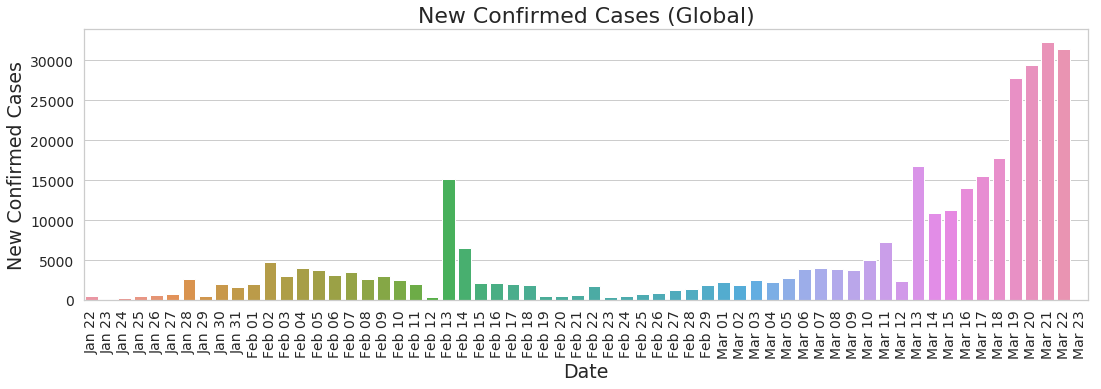

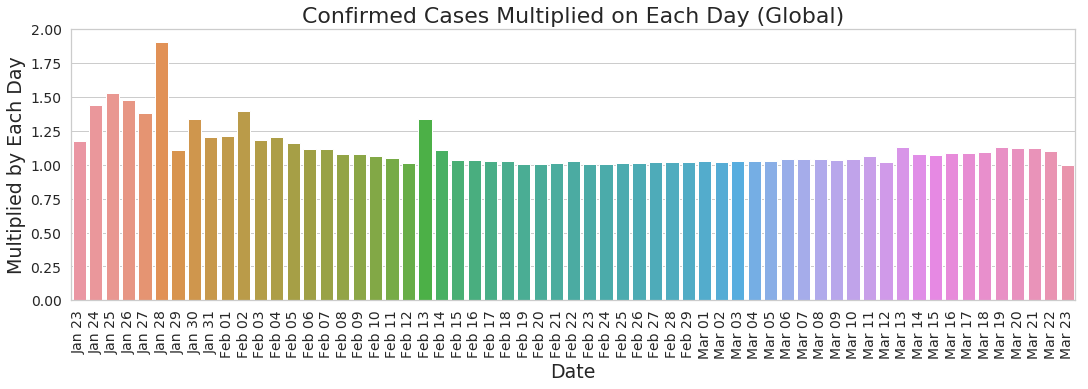

In [40]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Confirmed Cases (Global)"

xlabel   = "Date"
ylabel   = "New Confirmed Cases"

rotation = 90

sns.barplot(y = confirmed_total_add.values, x = data_cols)

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Confirmed Cases Multiplied on Each Day (Global)"

xlabel   = "Date"
ylabel   = "Multiplied by Each Day"

rotation = 90

sns.barplot(y=confirmed_total_mul.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



# title    = "New Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=confirmed_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

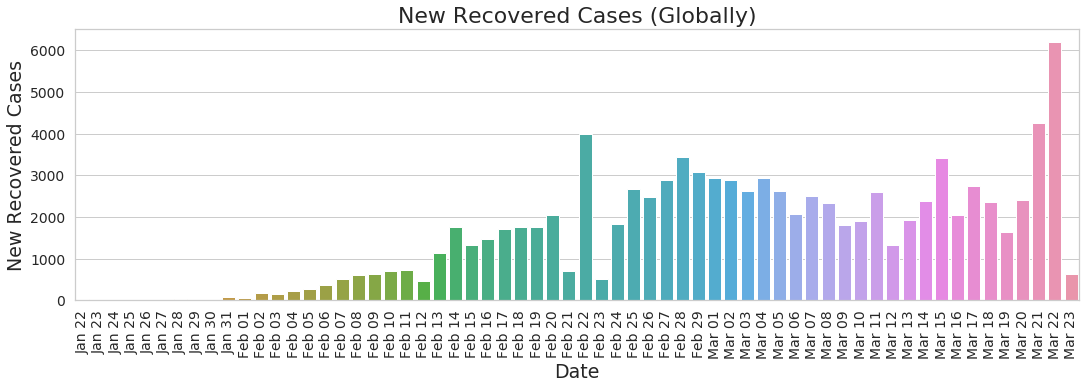

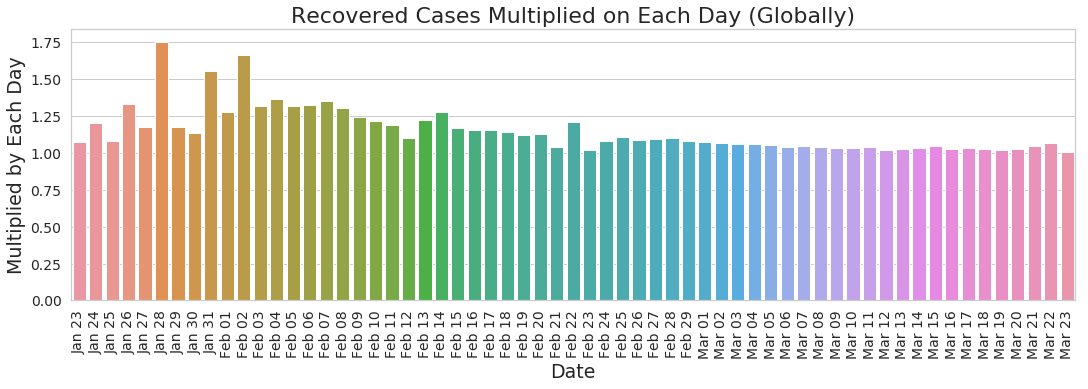

In [41]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Recovered Cases (Globally)"

xlabel   = "Date"
ylabel   = "New Recovered Cases"

rotation = 90


sns.barplot(y = recovered_total_add.values, x = data_cols)

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



title    = "Recovered Cases Multiplied on Each Day (Globally)"

xlabel   = "Date"
ylabel   = "Multiplied by Each Day"

rotation = 90

sns.barplot(y=recovered_total_mul.values[1:], x=data_cols[1:])

plt.title(title)

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.xticks(rotation=rotation)

plt.show() 



# title    = "New Recovered Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=recovered_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

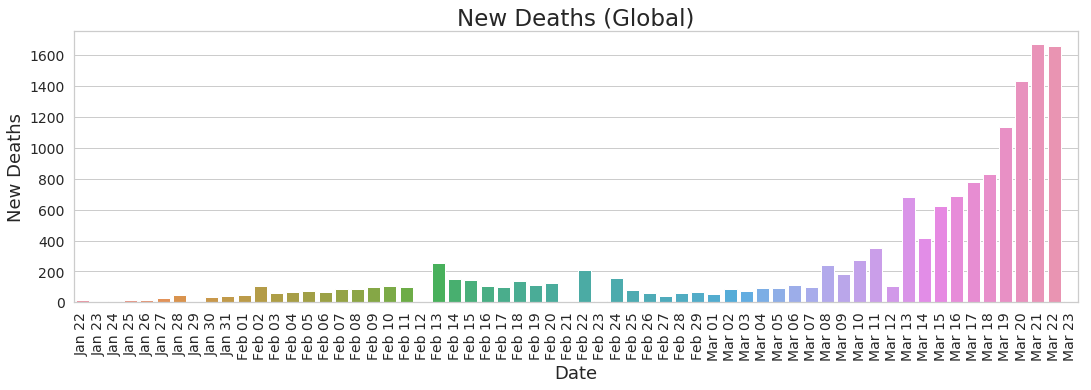

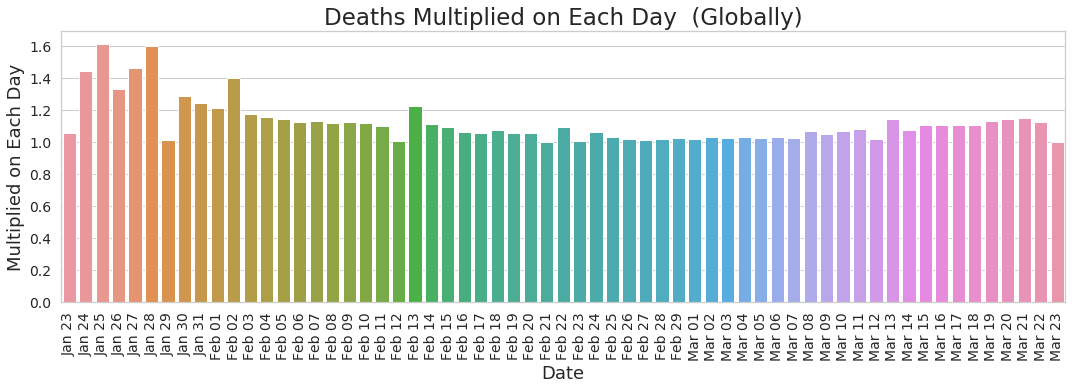

In [42]:
sns.set(style="whitegrid")

ticksize  = 14
labelsize = int(ticksize * 1.3)
titlesize = int(labelsize * 1.3)

figsize   = (18, 5)
params    = {'figure.figsize' : figsize,
             'axes.labelsize' : labelsize,
             'axes.titlesize' : titlesize,
             'xtick.labelsize': ticksize,
             'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title    = "New Deaths (Global)"
xlabel   = "Date"
ylabel   = "New Deaths"
rotation = 90

sns.barplot(y = death_total_add.values, x = data_cols)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=rotation)
plt.show() 



title    = "Deaths Multiplied on Each Day  (Globally)"
xlabel   = "Date"
ylabel   = "Multiplied on Each Day"
rotation = 90

sns.barplot(y=death_total_mul.values[1:], x=data_cols[1:])
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=rotation)
plt.show() 



# title    = "New Deaths Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90

# sns.barplot(y=death_total_inc.values[1:], x=data_cols[1:])
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.xticks(rotation=rotation)
# plt.show() 

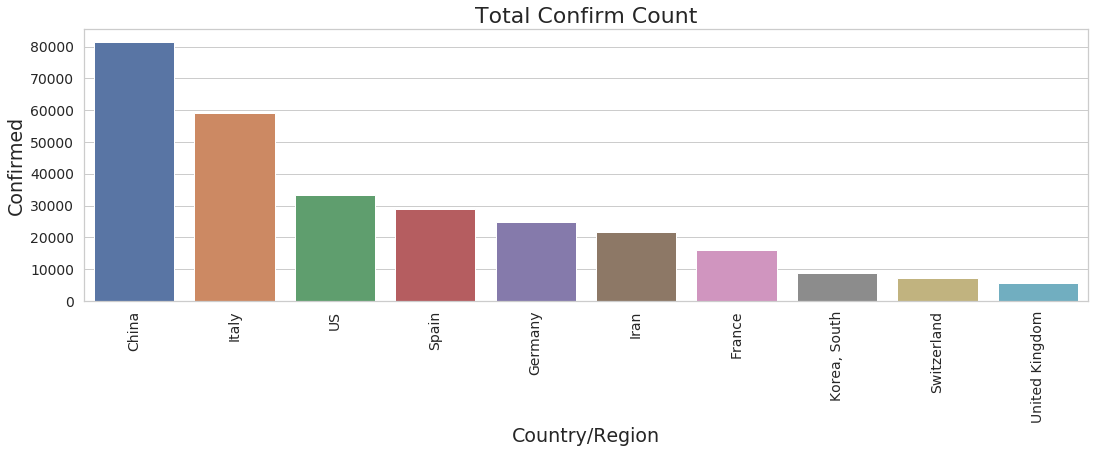

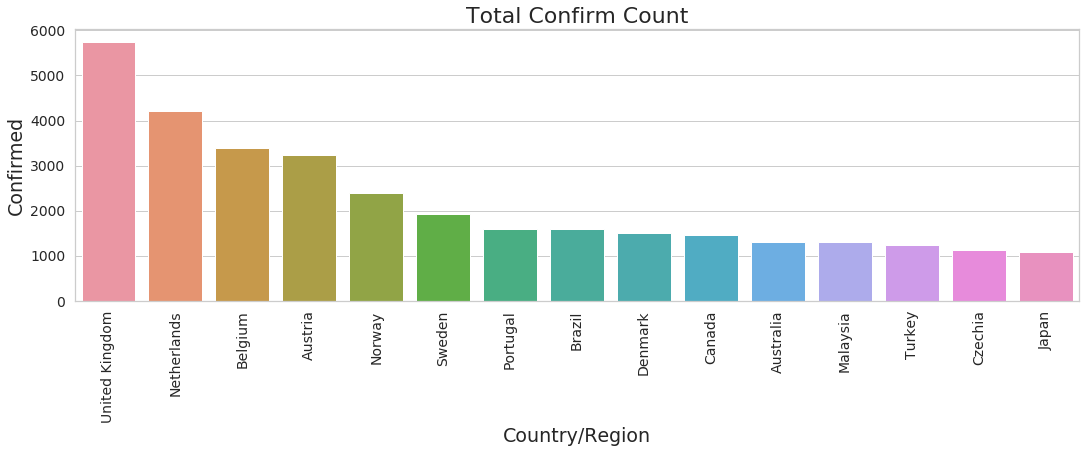

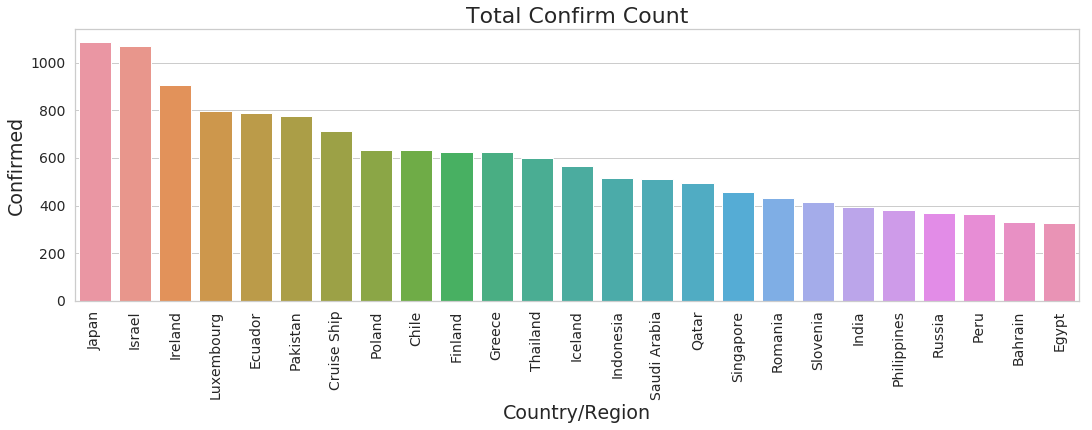

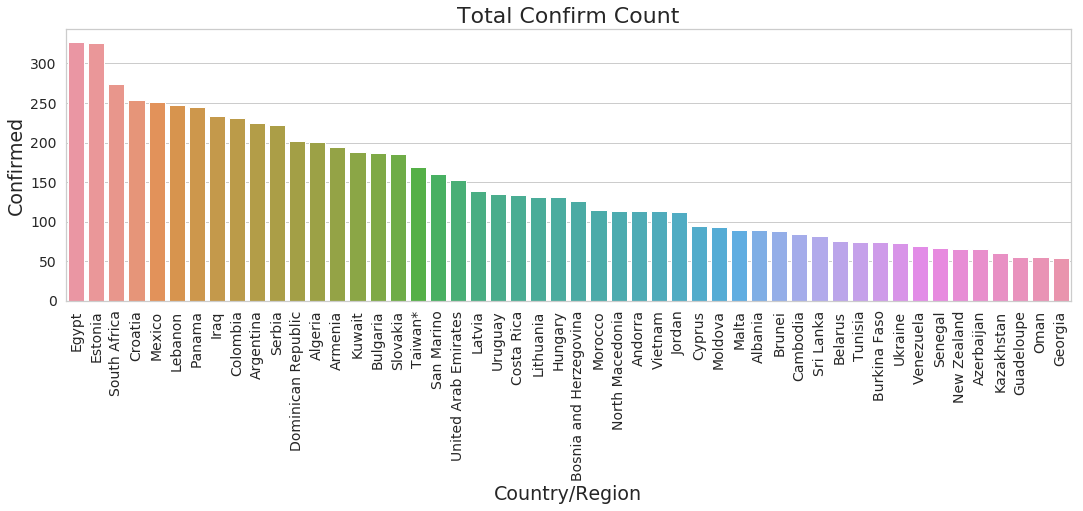

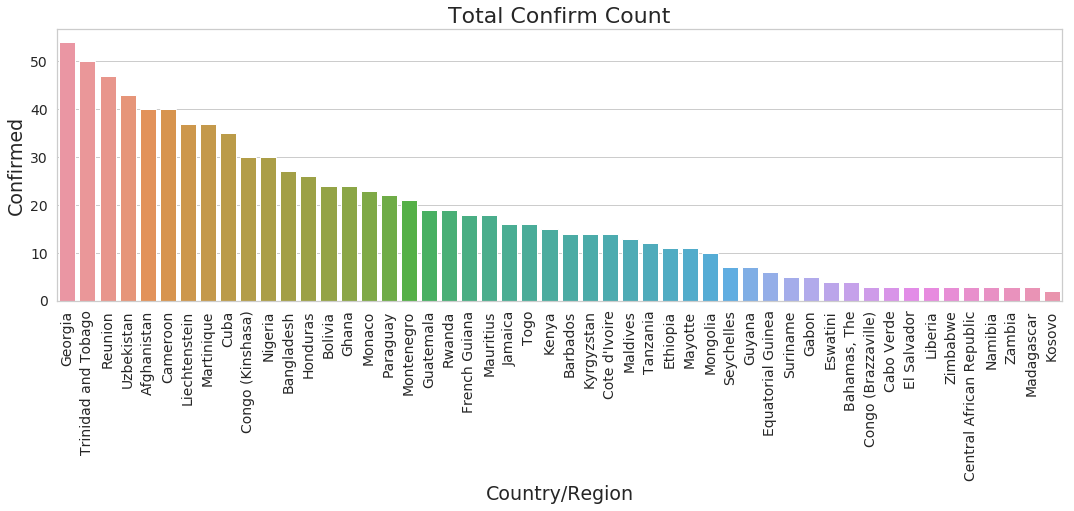

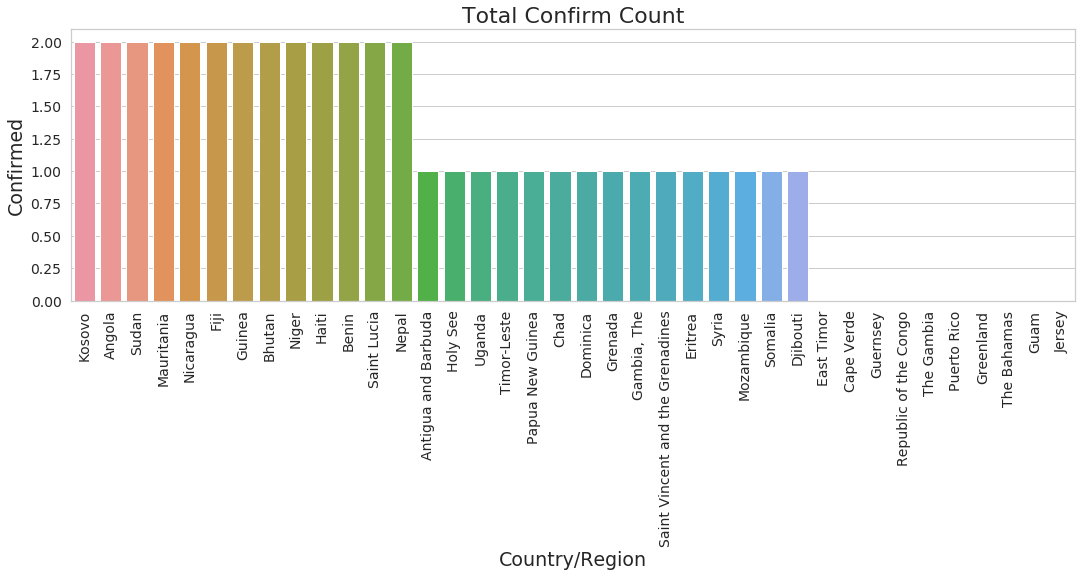

In [43]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Confirmed"
title = "Total Confirm Count"


df = result_country[[y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 15

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 25

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

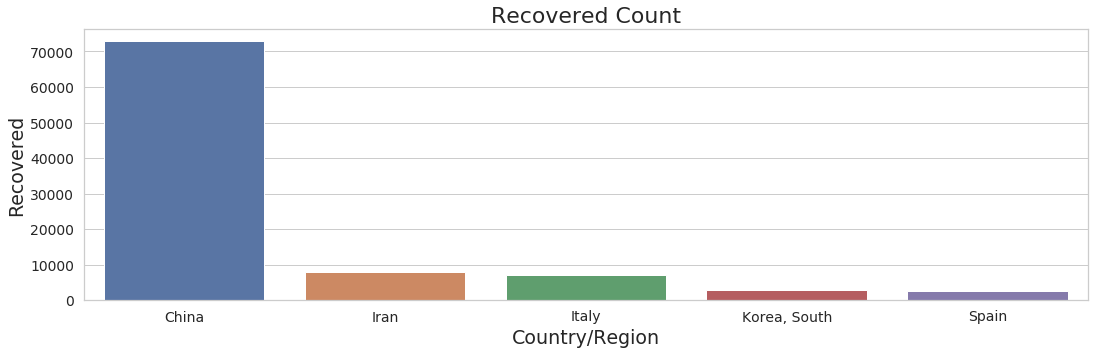

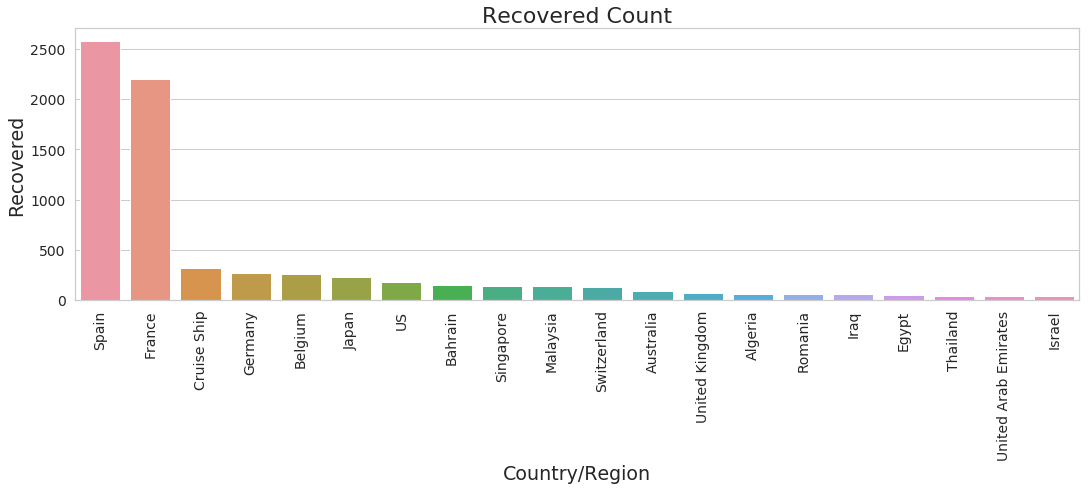

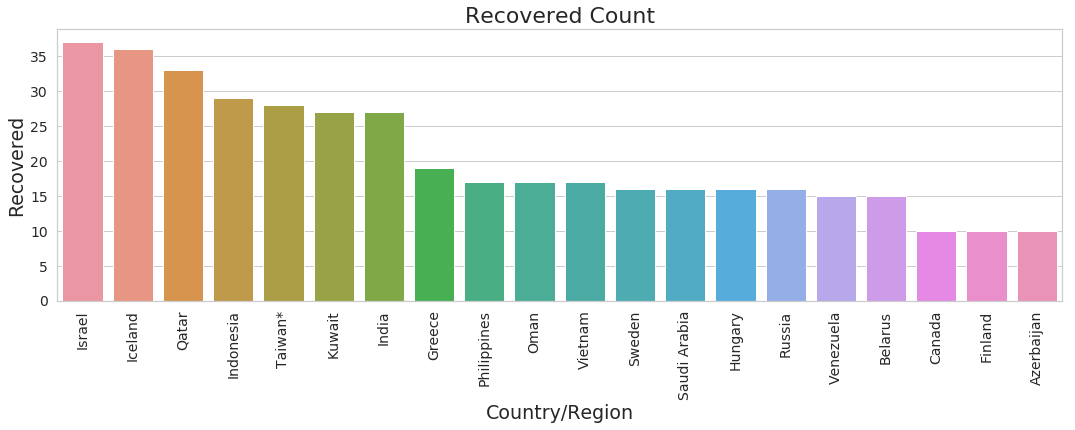

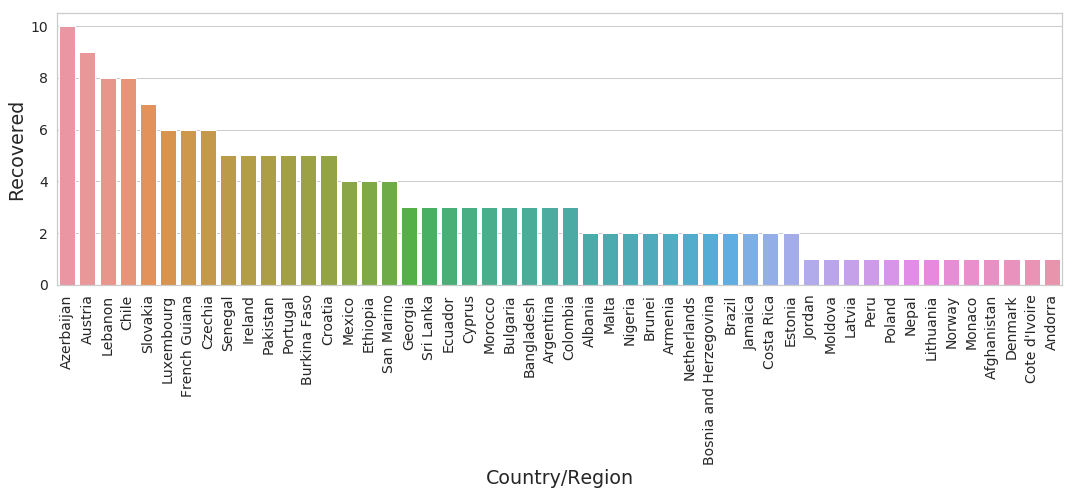

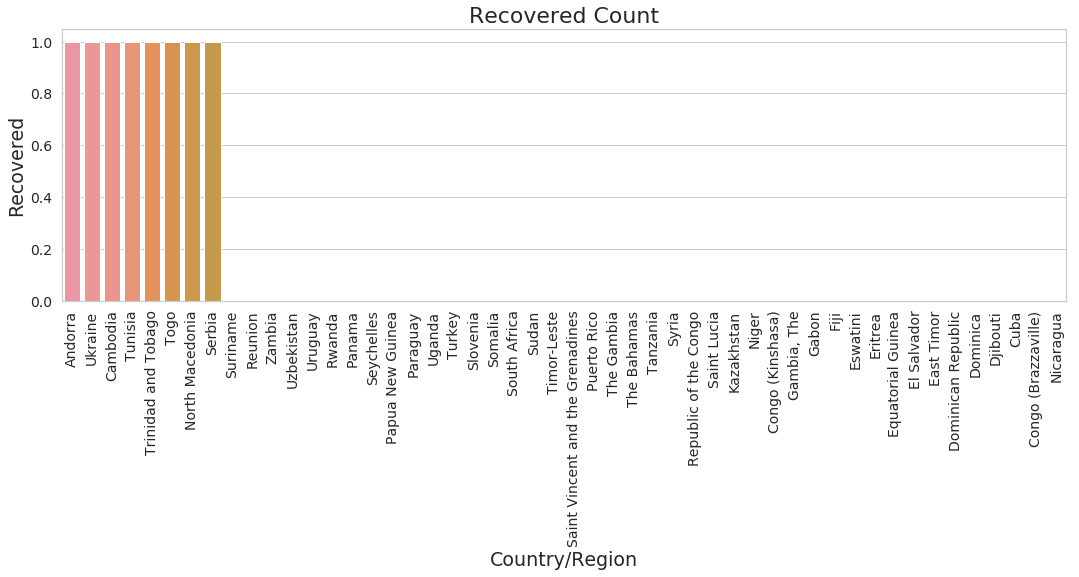

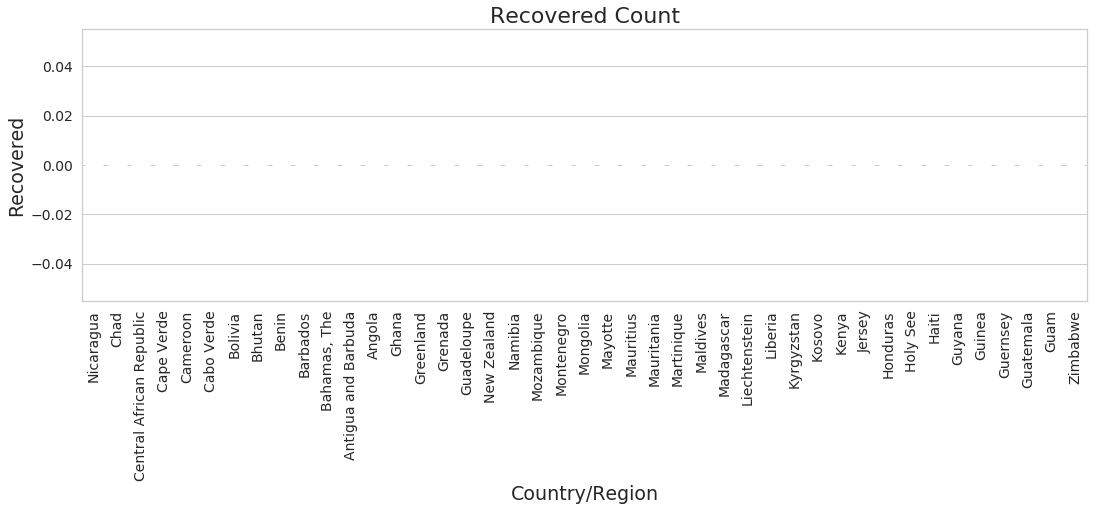

In [44]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Recovered"
title = "Recovered Count"


df = result_country[[y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 5
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
# plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 20

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 20

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
# plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

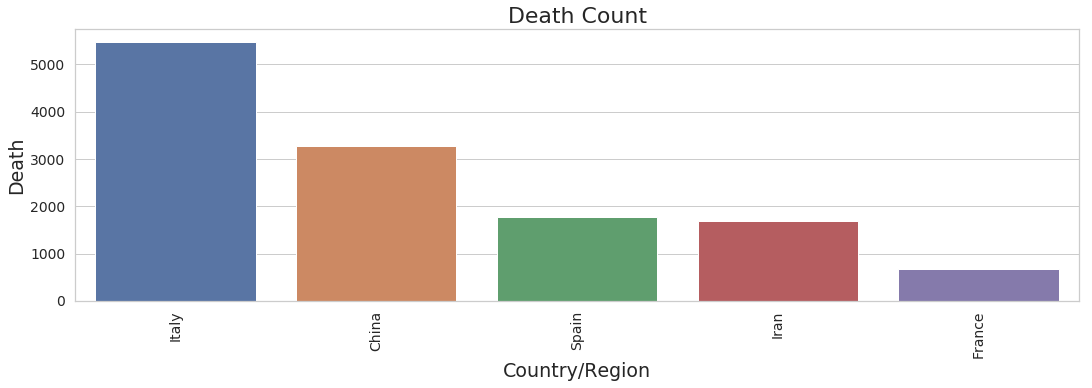

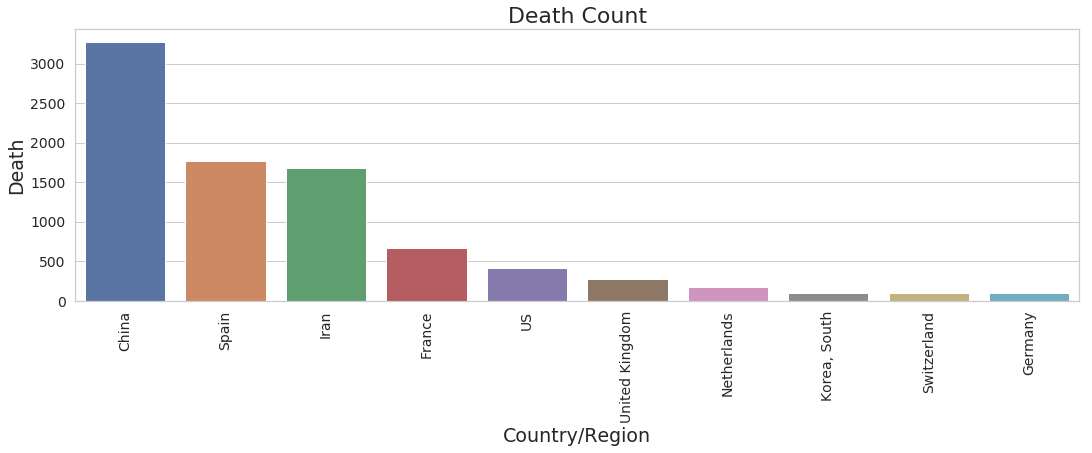

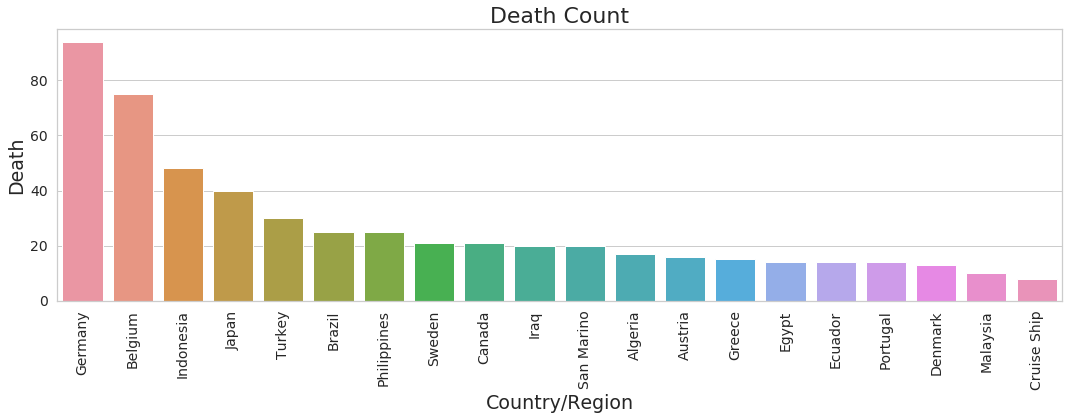

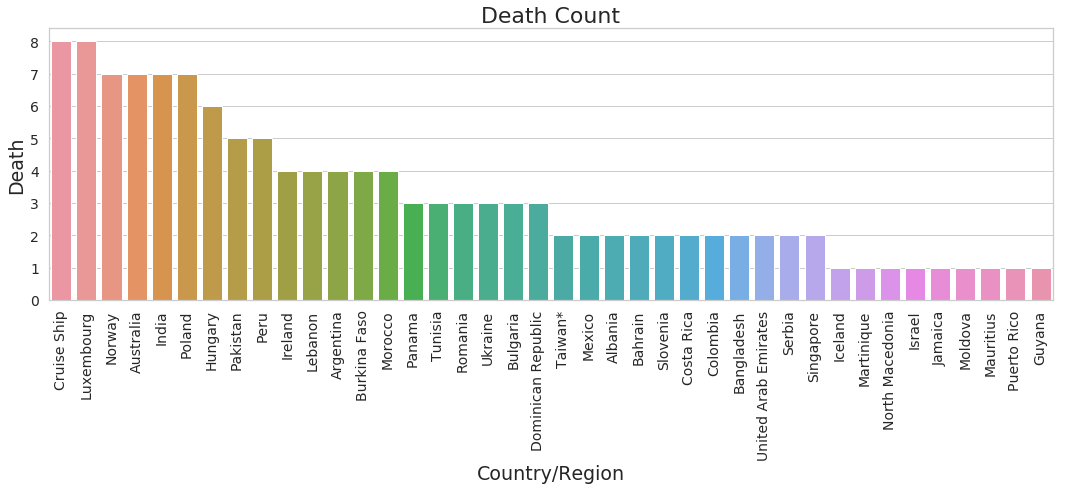

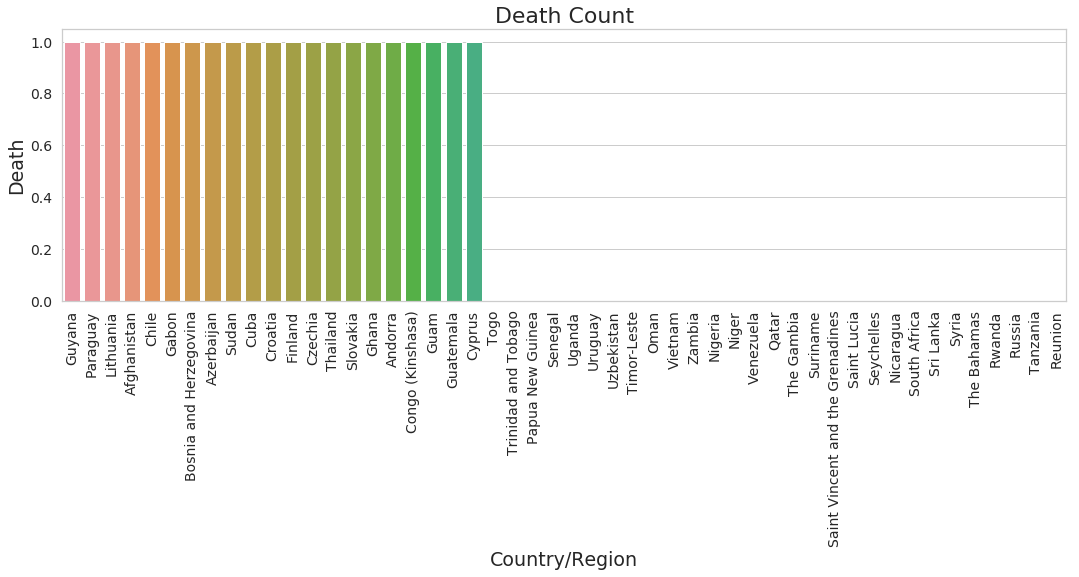

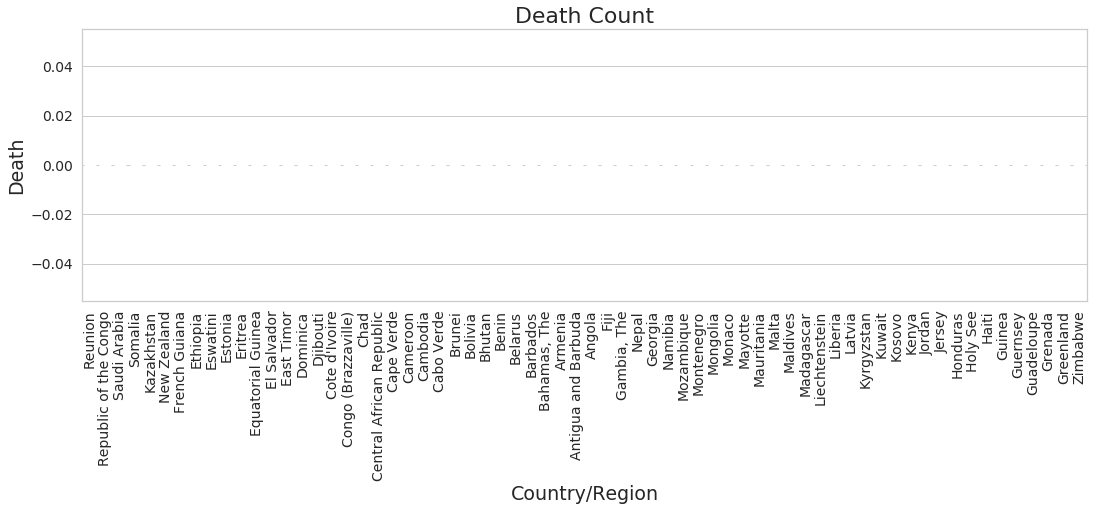

In [45]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Death"
title = "Death Count"


df = result_country[[y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 5
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = 1
max_count = 10

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 20

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 40

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

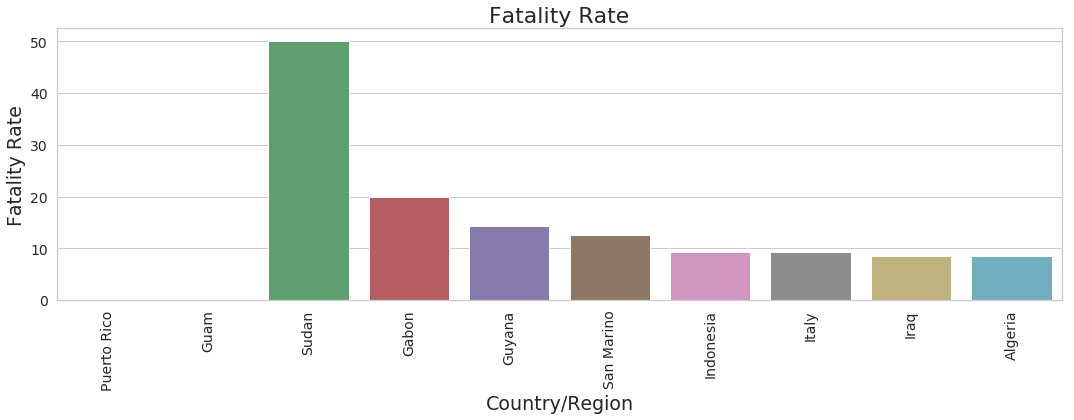

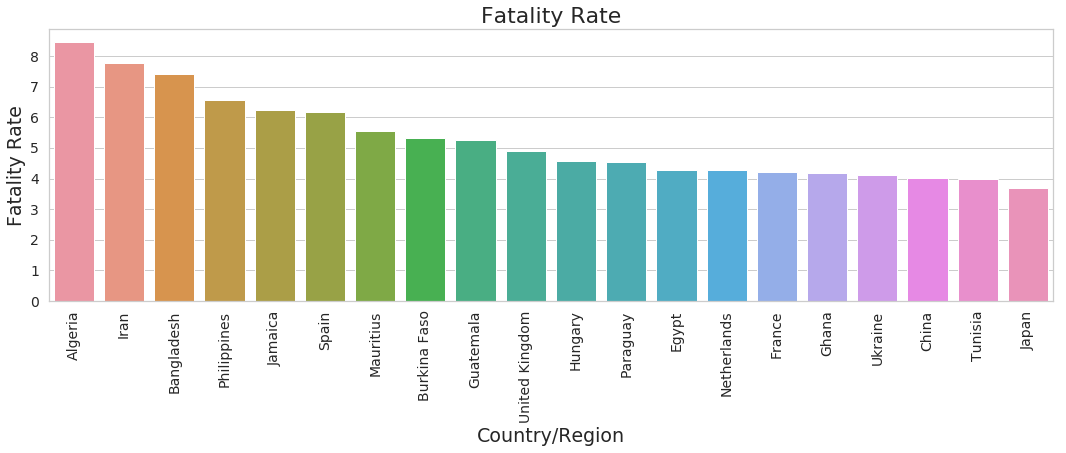

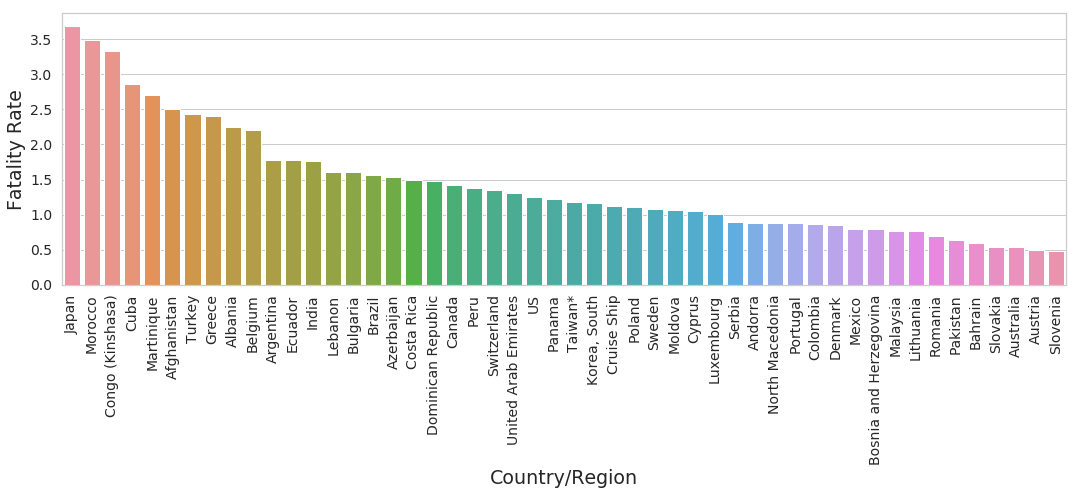

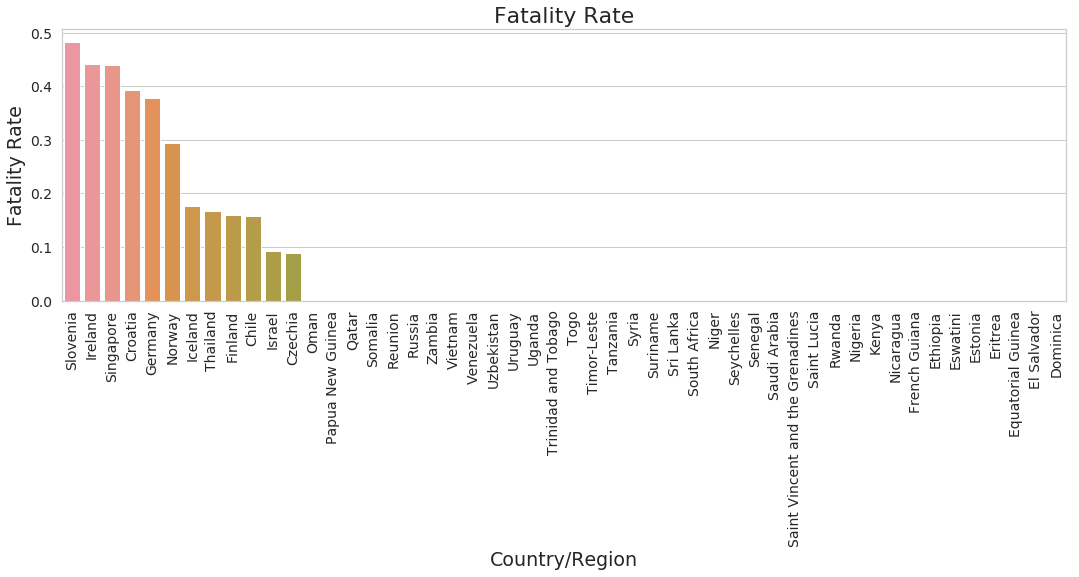

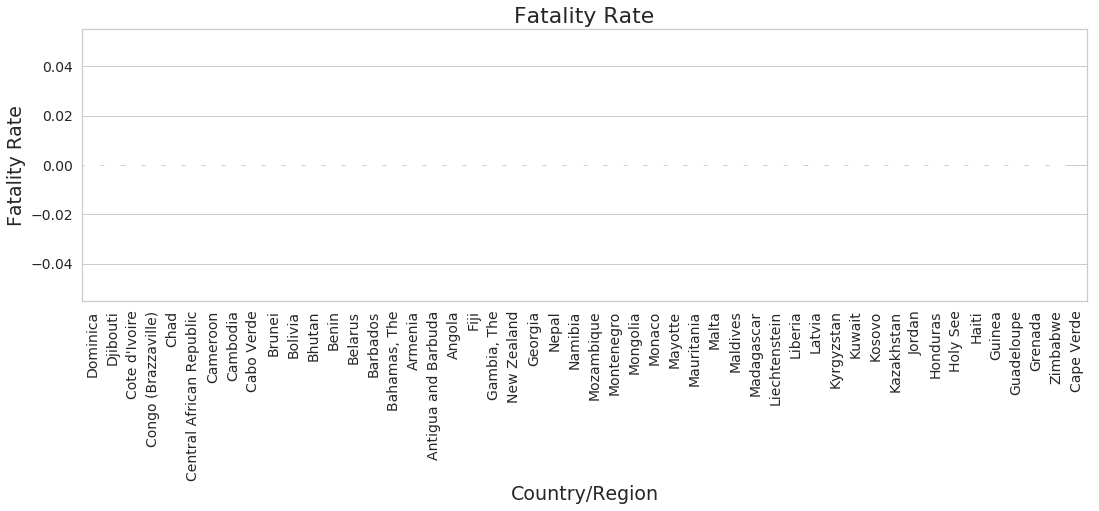

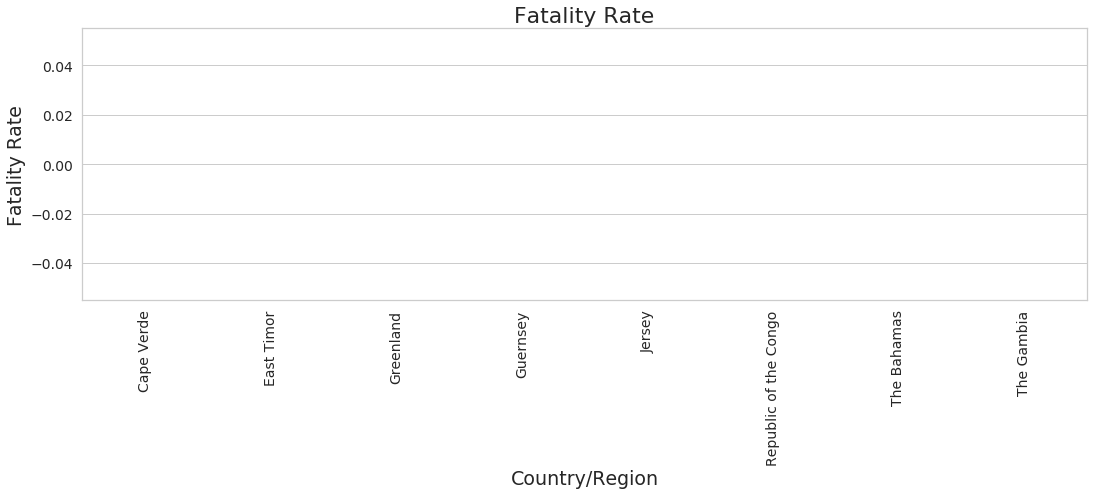

In [46]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Fatality Rate"
title = "Fatality Rate"


df = result_country[[y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 20

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
# plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

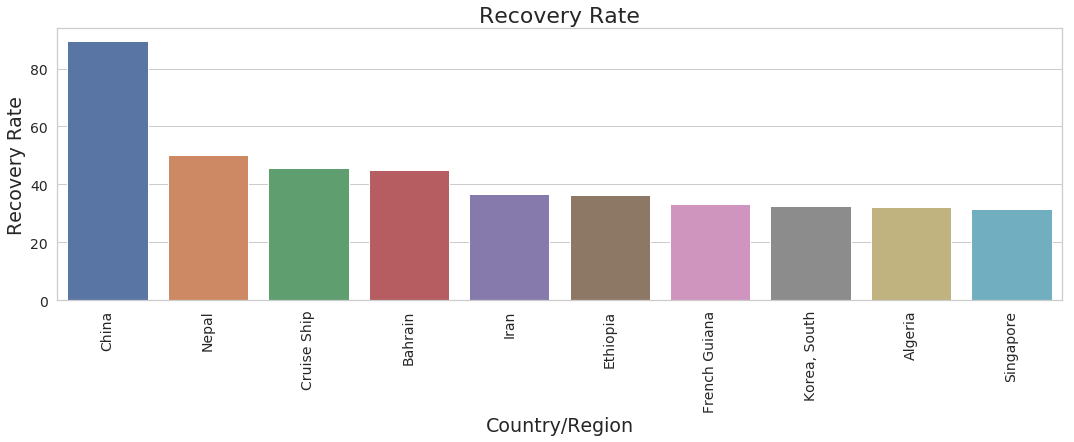

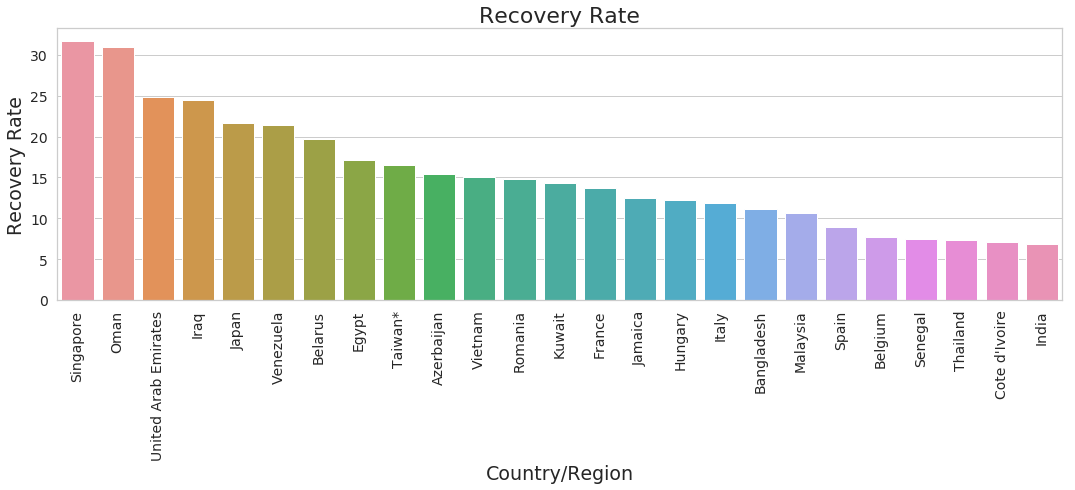

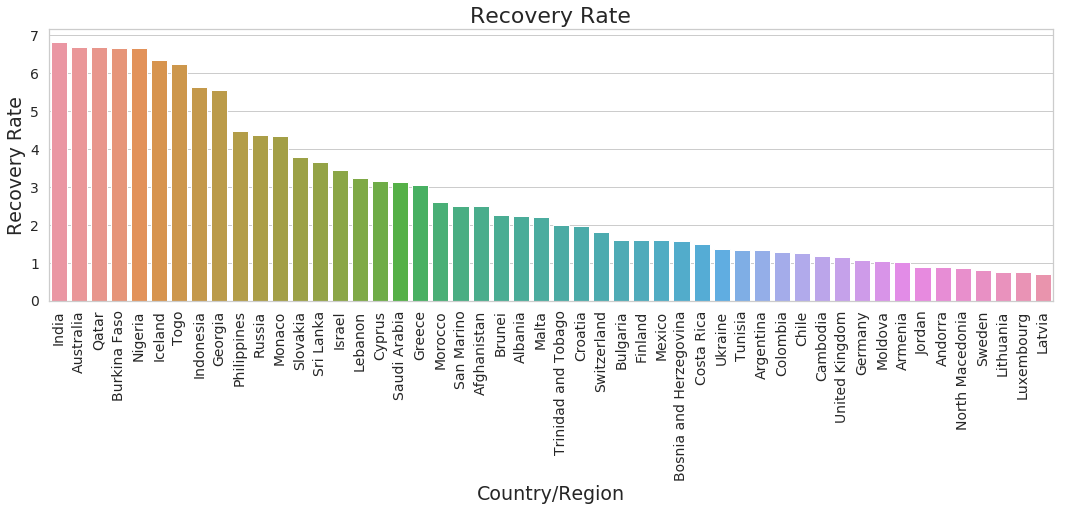

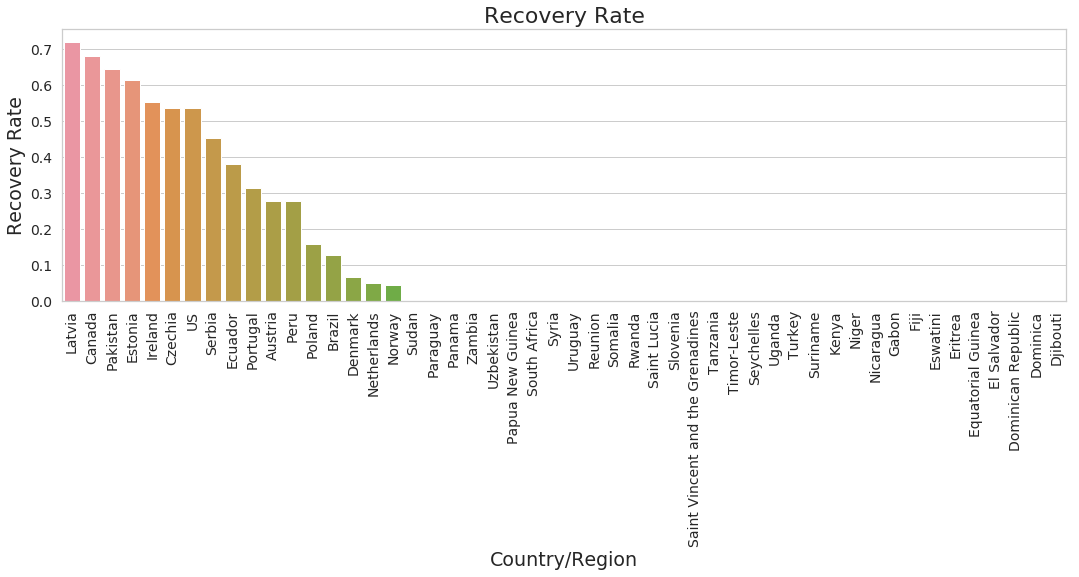

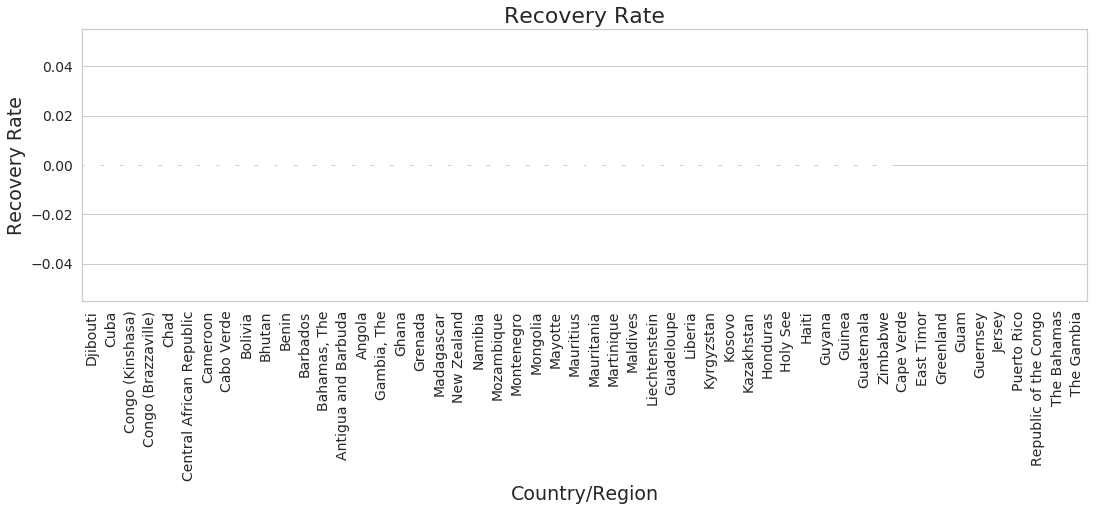

In [47]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


x_col = "Country/Region"
y_col = "Recovery Rate"
title = "Recovery Rate"


df = result_country[[y_col]].sort_values(by=y_col, ascending=False).reset_index()


max_count = 10
sns.barplot(x=x_col, y=y_col, data=df[:max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 




start = max_count - 1
max_count = 25

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: start + max_count])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 


start = start + max_count - 1
max_count = 50

sns.barplot(x=x_col, y=y_col, data=df[start: ])
plt.title(title)
plt.xticks(rotation=90)
plt.show() 

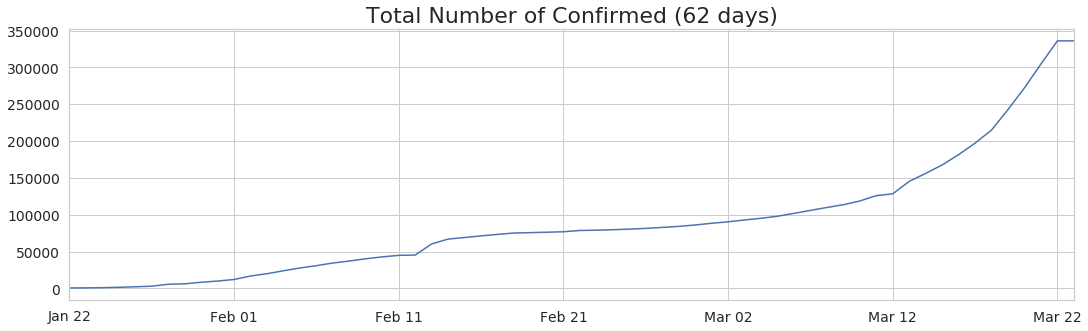

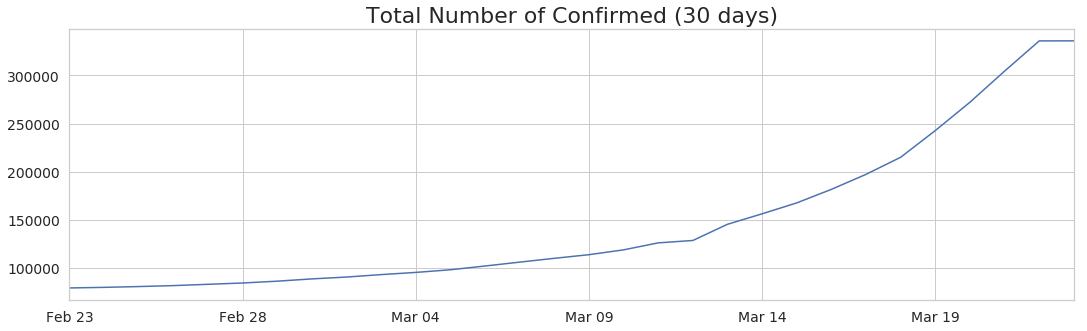

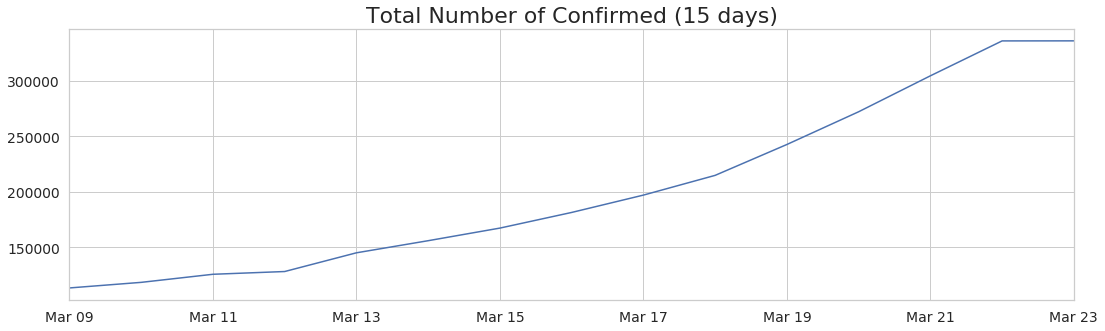

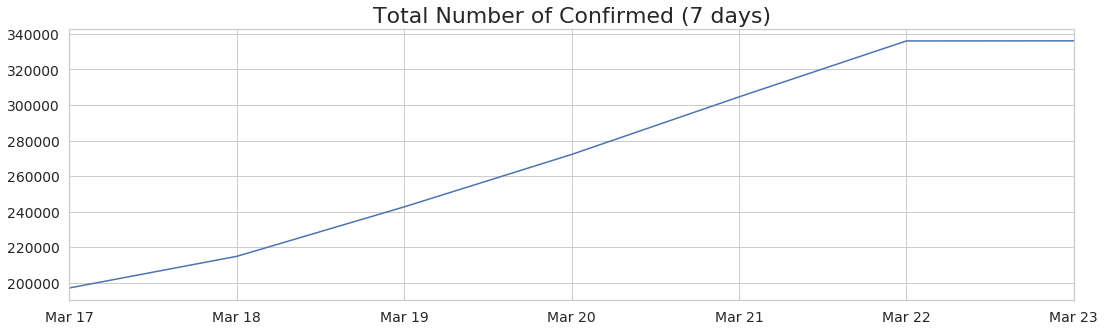

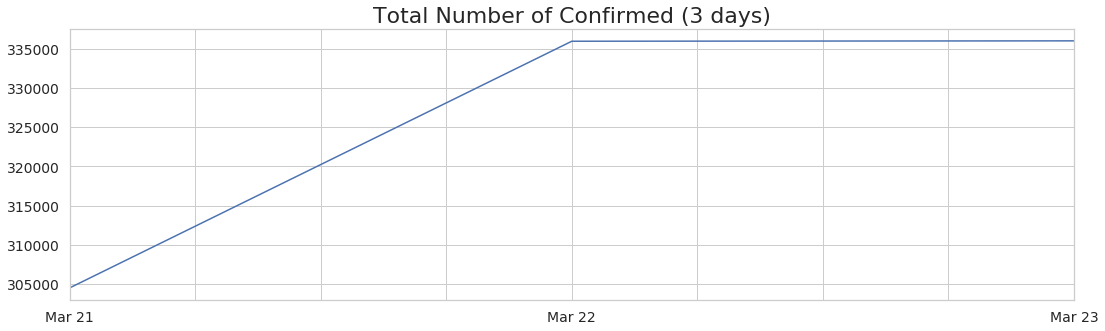

In [48]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}

df = time_series_covid_19_confirmed
title_key = " Confirmed "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

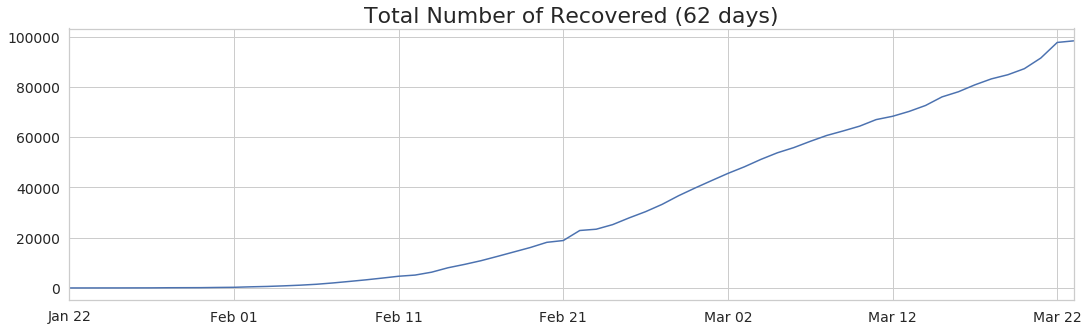

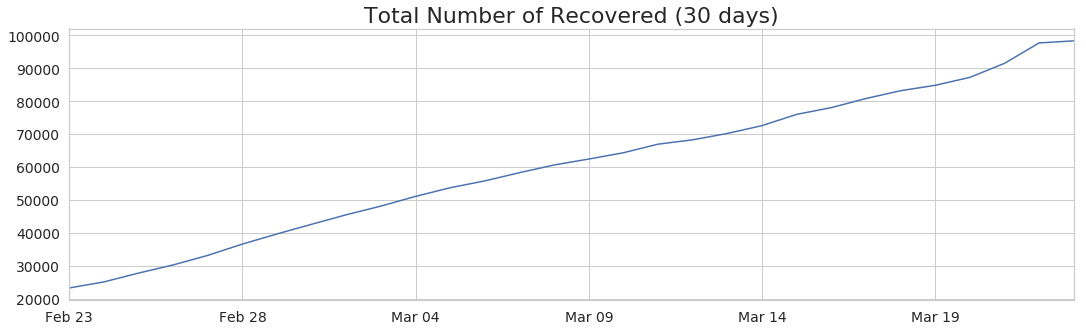

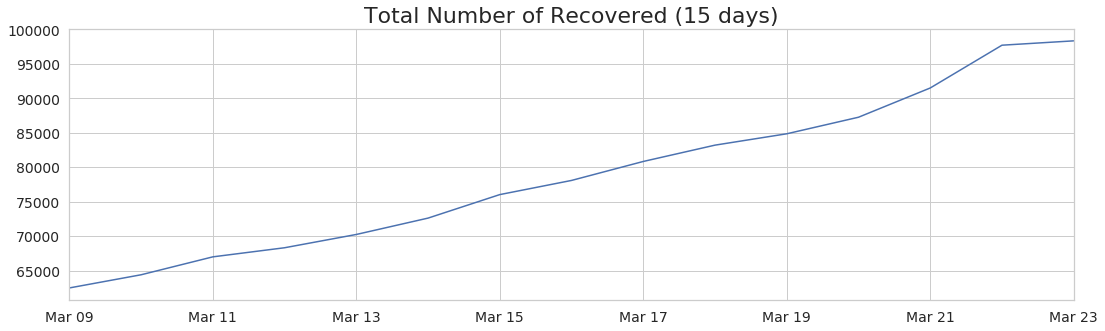

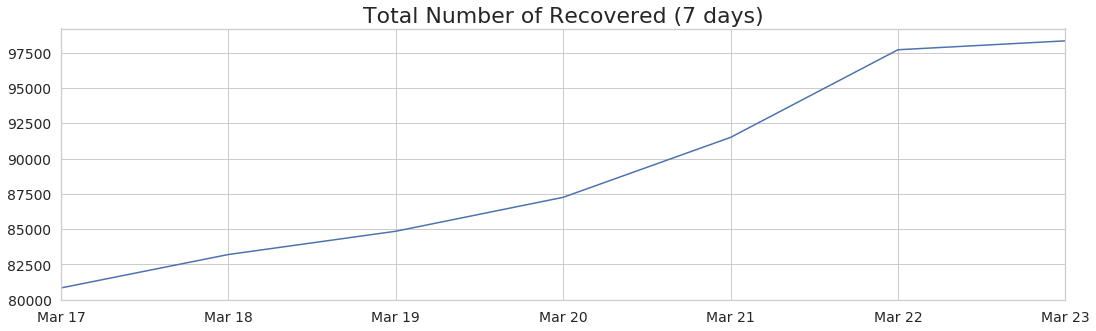

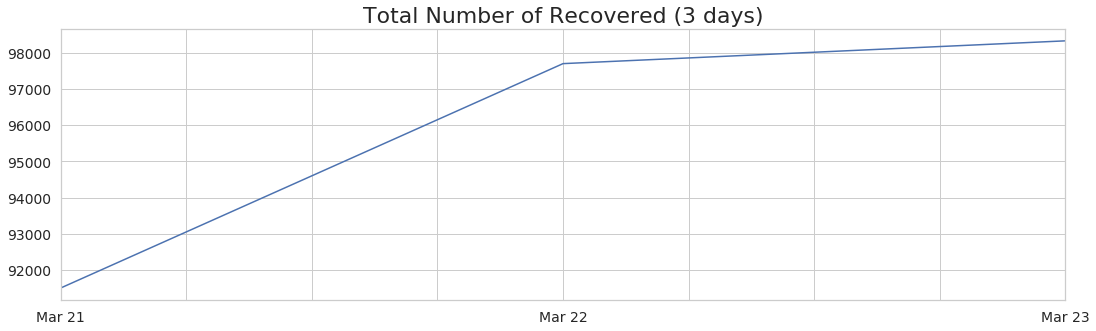

In [49]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}

df = time_series_covid_19_recovered
title_key = " Recovered "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

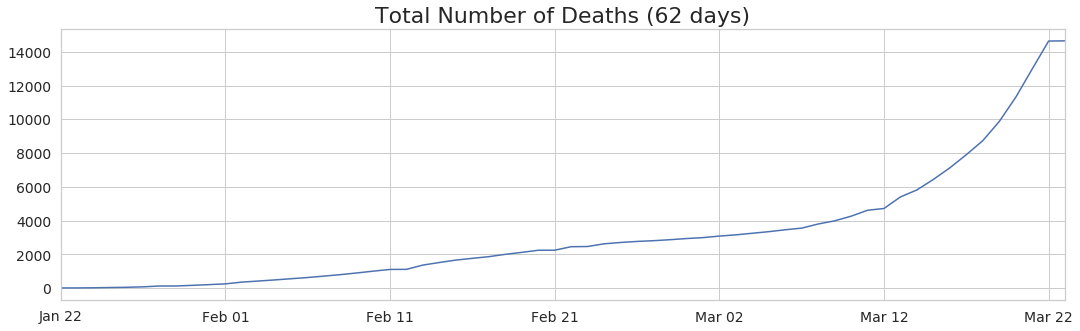

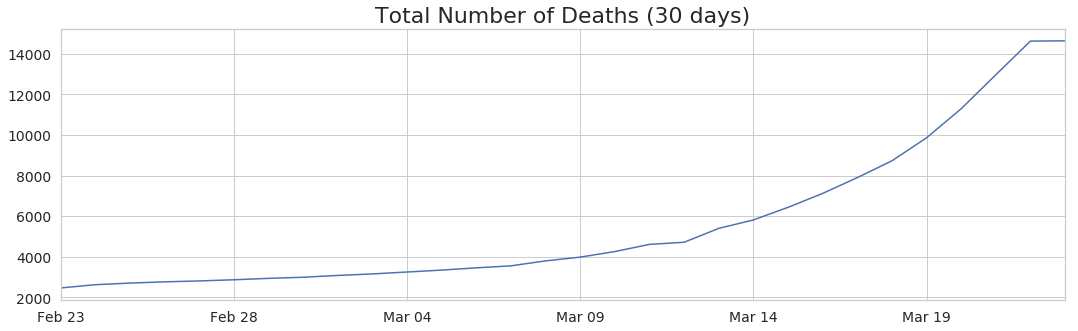

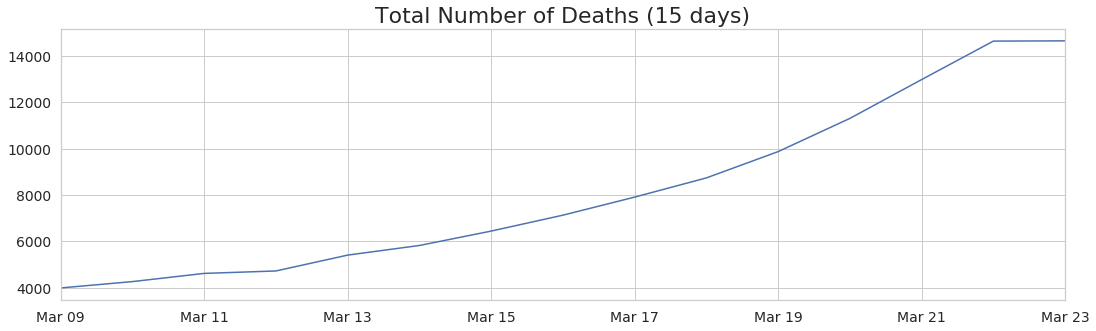

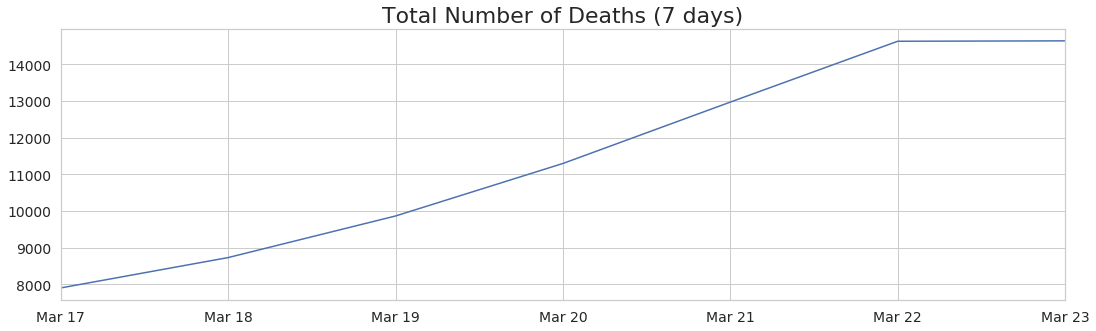

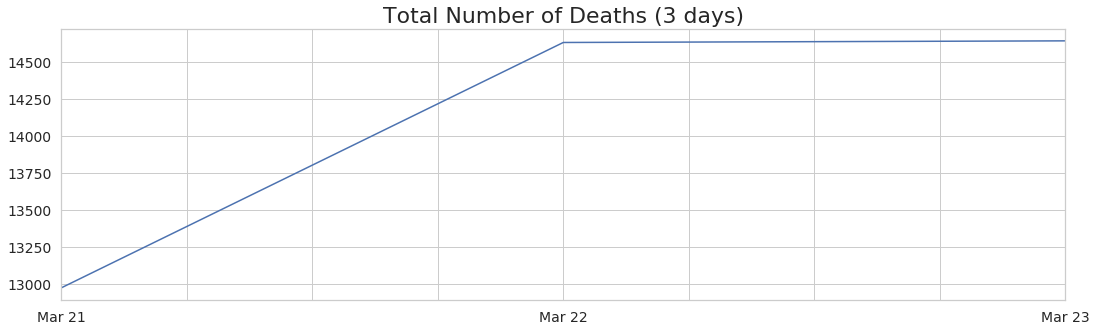

In [50]:
sns.set(style="whitegrid")

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line", 3: "line"}


df = time_series_covid_19_deaths
title_key = " Deaths "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

In [51]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Confirmed Cases"
# xlabel   = "Date"
# ylabel   = "New Confirmed Cases"
# rotation = 90


# for index, row in confirmed_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [52]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in confirmed_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [53]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Confirmed Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in confirmed_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [54]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Recovered Cases"
# xlabel   = "Date"
# ylabel   = "New Recovered Cases"
# rotation = 90


# for index, row in recovered_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [55]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Recovered Cases Multiplied on Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied on Each Day"
# rotation = 90


# for index, row in recovered_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [56]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Recovered Cases Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in recovered_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [57]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Deaths"
# xlabel   = "Date"
# ylabel   = "New Deaths"
# rotation = 90


# for index, row in death_country_add.iterrows():
#     sns.barplot(y = row[data_cols].values, x = data_cols)
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 


In [58]:
# sns.set(style="whitegrid")

# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "Deaths Multiplied on Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied on Each Day"
# rotation = 90


# for index, row in death_country_mul.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [59]:
# sns.set(style="whitegrid")

# ticksize  = 12
# labelsize = int(ticksize * 1.3)
# titlesize = int(labelsize * 1.3)

# figsize   = (18, 5)
# params    = {'figure.figsize' : figsize,
#              'axes.labelsize' : labelsize,
#              'axes.titlesize' : titlesize,
#              'xtick.labelsize': ticksize,
#              'ytick.labelsize': ticksize}

# plt.rcParams.update(params)


# title    = "New Death Multiplied by Each Day"
# xlabel   = "Date"
# ylabel   = "Multiplied by Each Day"
# rotation = 90


# for index, row in death_country_inc.iterrows():
#     sns.barplot(y = row[data_cols].values[1:], x = data_cols[1:])
#     plt.title(title + " ( " + index + " )")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks(rotation=rotation)
#     plt.show() 

In [60]:
# time_series_covid_19_confirmed[data_cols].fillna(0, inplace=True)
# time_series_covid_19_recovered[data_cols].fillna(0, inplace=True)
# time_series_covid_19_deaths[data_cols].fillna(0, inplace=True)

In [61]:
# from mpl_toolkits.basemap import Basemap

# plt.figure(figsize=(8, 8))
# m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
# m.bluemarble(scale=0.5);


In [62]:
# # cities = pd.read_csv('data/california_cities.csv')

# df = time_series_covid_19_confirmed
# # Extract the data we're interested in
# lat = df['Lat'].values
# lon = df['Long'].values
# confirm_last = df[last_day].values
# # area = cities['area_total_km2'].values

In [63]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=37.5, lon_0=-119,
#             width=1E6, height=1.2E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=np.log10(population),
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');